<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-данных-из-файла,-предобработка" data-toc-modified-id="Изучение-данных-из-файла,-предобработка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных из файла, предобработка</a></span></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Разбиение-данных-на-обучающую-и-тестовую-выборки" data-toc-modified-id="Разбиение-данных-на-обучающую-и-тестовую-выборки-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Разбиение данных на обучающую и тестовую выборки</a></span></li><li><span><a href="#Построение-константной-модели" data-toc-modified-id="Построение-константной-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Построение константной модели</a></span></li><li><span><a href="#Построение-модели-без-учёта-дисбаланса-классов" data-toc-modified-id="Построение-модели-без-учёта-дисбаланса-классов-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Построение модели без учёта дисбаланса классов</a></span></li><li><span><a href="#Построение-моделей-с-учётом-дисбаланса-классов" data-toc-modified-id="Построение-моделей-с-учётом-дисбаланса-классов-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Построение моделей с учётом дисбаланса классов</a></span><ul class="toc-item"><li><span><a href="#Модель-логистической-регрессии" data-toc-modified-id="Модель-логистической-регрессии-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Модель логистической регрессии</a></span></li><li><span><a href="#Модель-&quot;Дерево-решений&quot;" data-toc-modified-id="Модель-&quot;Дерево-решений&quot;-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Модель "Дерево решений"</a></span></li><li><span><a href="#Модель-&quot;Случайный-лес&quot;" data-toc-modified-id="Модель-&quot;Случайный-лес&quot;-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Модель "Случайный лес"</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Прогнозирование оттока клиентов банка

Из «Бета-Банка» стали уходить клиенты. Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Для анализа предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

В проекте необходимо построить модель с предельно большим значением F1-меры (не менее 0,59). Дополнительно следует измерить метрику AUC-ROC и сравнить её значение с F1-мерой.

## Изучение данных из файла, предобработка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

Загрузим данные из файла и ознакомимся с таблицей. После первого просмотра данных выяснилось, что в них имеется столбец RowNumber, содержащий номера строк, начиная с 1. Имеет смысл при загрузке данных сделать этот столбец индексным. 

In [2]:
try:
    main_data = pd.read_csv('Churn.csv', index_col='RowNumber')
except:
    main_data = pd.read_csv('/datasets/Churn.csv', index_col='RowNumber')
main_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


В таблице следует изменить названия столбцов с применением змеиного регистра. В столбце Tenure имеются пропуски, которые необходимо заполнить перед обучением будущих моделей.

Начнём с изменения названий столбцов и индексов. Воспользуемся одним регулярным выражением и командами для работы со строками.

In [3]:
main_data.columns = main_data.columns.str.replace(r"([A-Z])", r" \1", regex=True).str.lower().str.replace(' ', '_').str[1:]
main_data.index.name = 'row_number'

Посмотрим непосредственно на сами данные.

In [4]:
main_data.head(10)

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
row_number,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0


Столбец Tenure помимо наличия пропусков имеет также вещественный тип данных, но при этом дробная часть чисел никак не используется. Нужно преобразовать тип данных столбца в целочисленный.
Сначал заполним пропуски. Для заполнения используем медианное значение по столбцу.

In [5]:
main_data['tenure'].fillna(main_data['tenure'].median(), inplace=True)
main_data['tenure'].isna().sum()

0

Пропуски успешно заполнились медианными значениями. Теперь преобразуем тип данных столбца.

In [6]:
main_data['tenure'] = main_data['tenure'].astype('int')
main_data['tenure'].head(5)

row_number
1    2
2    1
3    8
4    1
5    2
Name: tenure, dtype: int32

Преобразование типа данных прошло успешно.

В четырёх столбцах должно содержаться только не более двух уникальных значений. Проверим это.

In [7]:
display(main_data['gender'].unique())
display(main_data['has_cr_card'].unique())
display(main_data['is_active_member'].unique())
display(main_data['exited'].unique())

array(['Female', 'Male'], dtype=object)

array([1, 0], dtype=int64)

array([1, 0], dtype=int64)

array([1, 0], dtype=int64)

C уникальными значениями в рассмотренных столбцах всё в порядке.

Проверим также некоторые столбцы на наличие аномальных значений.

In [8]:
display(main_data['credit_score'].describe())
display(main_data['balance'].describe())
display(main_data['estimated_salary'].describe())

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: credit_score, dtype: float64

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: balance, dtype: float64

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64

Явных аномалий в столбцах не замечено. Предобработка данных на этом этапе закончена.

## Подготовка признаков

В таблице имеются столбцы с категориальными признаками. Необходимо их преобразовать с помощью техники прямого кодирования. При этом не стоит забывать про дамми-ловушку.

Перед выполнением прямого кодирования из таблицы следует удалить столбец surname. Он не несёт никакой практической пользы в дальнейшем при обучении моделей, а при прямом кодировании от столбца surname в таблице появится огромное число других столбцов (по числу уникальных значений столбца). Также удалим столбец customer_id, так как он тоже не несёт смысла для обучения моделей.

In [9]:
main_data_p = main_data.drop(['surname','customer_id'], axis=1)
main_data_p = pd.get_dummies(main_data_p, drop_first=True)

In [10]:
main_data_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  int32  
 3   balance            10000 non-null  float64
 4   num_of_products    10000 non-null  int64  
 5   has_cr_card        10000 non-null  int64  
 6   is_active_member   10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Male        10000 non-null  uint8  
dtypes: float64(2), int32(1), int64(6), uint8(3)
memory usage: 771.5 KB


Прямое кодирование прошло успешно, избыточные столбцы при этом удалились. Так как в дальнейшем одна из моделей будет линейной, то нужно выполнить масштабирование количественных признаков. Но делать это нужно после разделения на выборки. Масштабирование будет выполнено в разделе 3.

Исследуем баланс классов в столбце с целевым признаком.

In [11]:
main_data_p['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

Нулевых значений почти в четыре раза больше, чем единичных. Это нужно учесть в дальнейшем при подготовке выборок (использовать стратификацию по целевому признаку) и при обучении моделей (учесть баланс классов). 

На этом подготовка и исследование признаков завершены.

## Разбиение данных на обучающую и тестовую выборки

Так как для исследований нет отдельной спрятанной тестовой выборки, то придётся исходный набор данных делить на две выборки: обучающую и тестовую в соотношении 80%:20%. Валидационную выборку выделять нет необходимости, так как при создании моделей либо не будет подбора гиперпараметров, либо будет использоваться функция GridSearchCV, которая будет выделять валидационные выборки самостоятельно. 

Для получения выборок используем функцию train_test_split. Будем использовать стратификацию по целевым признакам, так как они распределены неравномерно в исходной таблице.

In [12]:
train_data, test_data = train_test_split(
    main_data_p,test_size=0.2,train_size=0.8, stratify=main_data_p['exited'], random_state=123)

In [13]:
print(train_data.shape)
print(test_data.shape)

(8000, 12)
(2000, 12)


Разбиение данных на выборки прошло успешно. Теперь выделим из выборок обычные и целевые признаки.

In [14]:
train_valid_features = train_data.drop(columns=['exited'])
train_valid_target = train_data['exited']
test_features = test_data.drop(columns=['exited'])
test_target = test_data['exited']

Теперь выполним масштабирование количественных признаков. Преобразователь масштаба будет обучаться на обучающей выборке, а затем применяться к обоим выборкам (к обучающей, а также к тестовой). Масштабирование применяется только для обычных признаков (целевые признаки не следует масштабировать).

In [15]:
numeric = ['credit_score','age', 'tenure','balance','num_of_products','estimated_salary']
scaler = StandardScaler()

scaler.fit(train_valid_features[numeric])
train_valid_features[numeric] = scaler.transform(train_valid_features[numeric])
test_features[numeric] = scaler.transform(test_features[numeric])

display(train_valid_features.head(3))
display(test_features.head(3))

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
row_number,,,,,,,,,,,
9386,0.382227,0.487923,1.091605,0.308125,0.825039,1,1,-1.712869,1,0,1
2156,0.101876,-0.379067,0.365743,0.394675,-0.914174,1,0,-1.409809,0,0,0
769,0.351077,0.198926,-1.085979,0.699392,0.825039,0,0,0.349622,0,1,1


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
row_number,,,,,,,,,,,
2376,1.711299,0.006262,0.365743,-1.220239,-0.914174,1,1,-0.261602,0,1,0
2822,0.662579,-0.571732,1.817466,0.432377,0.825039,1,1,-0.879423,0,1,0
6970,-0.323842,-0.090071,0.365743,-1.220239,0.825039,1,1,0.303177,0,1,0


Масштабирование прошло успешно.

## Построение константной модели

Чтобы лучше осознавать адекватность построения будущих моделей, посчитаем метрики качества для константной модели, которая будет всегда предсказывать единичные значения.

In [16]:
dummy_model = DummyClassifier(strategy='constant', constant=1, random_state=123)
dummy_model.fit(train_valid_features, train_valid_target)
test_predictions = dummy_model.predict(test_features)
score1 = accuracy_score(test_target, test_predictions)
score2 = f1_score(test_target, test_predictions)
test_probabilities_one = dummy_model.predict_proba(test_features)[:,1]
score3 = roc_auc_score(test_target, test_probabilities_one)
print(f'Константная модель имеет значение accuracy: {score1:.5f}')
print(f'Константная модель имеет значение F1-меры: {score2:.5f}')
print(f'Константная модель имеет значение AUC-ROC: {score3:.5f}')

Константная модель имеет значение accuracy: 0.20350
Константная модель имеет значение F1-меры: 0.33818
Константная модель имеет значение AUC-ROC: 0.50000


**Вывод:** при построении константной модели, предсказывающей всегда единичные значения, получились ожидаемо крайне низкие значения метрик качества. Планируемые к построению в дальнейшем реальные модели должны значительно превысить значения рассмотренных метрики качества, особенно F1-меру.

## Построение модели без учёта дисбаланса классов

Построим модель логистической регрессии без учёта дисбаланса классов. Так как в этой модели не будет подбора гиперпараметров, то обучать её можно сразу на обучающей выборке. Предсказания модели будем получать по тестовой выборке. 

Так как в дальнейшем код создания и обучения модели будет повторяться, напишем функцию.

In [17]:
def logistic_regression_routine(train_features, train_target, class_weight):
    model = LogisticRegression(class_weight=class_weight, solver='liblinear', random_state=123)
    model.fit(train_features, train_target)
    test_predictions = model.predict(test_features)
    score1 = accuracy_score(test_target, test_predictions)
    score2 = f1_score(test_target, test_predictions)
    test_probabilities_one = model.predict_proba(test_features)[:,1]
    score3 = roc_auc_score(test_target, test_probabilities_one)
    print(f'Модель логистической регрессии имеет значение accuracy: {score1:.5f}')
    print(f'Модель логистической регрессии имеет значение F1-меры: {score2:.5f}')
    print(f'Модель логистической регрессии имеет значение AUC-ROC: {score3:.5f}')

logistic_regression_routine(train_valid_features, train_valid_target, None)

Модель логистической регрессии имеет значение accuracy: 0.81100
Модель логистической регрессии имеет значение F1-меры: 0.33684
Модель логистической регрессии имеет значение AUC-ROC: 0.75764


**Вывод:** при построении модели логистической регрессии без учёта дисбаланса классов получилось неудовлетворительное значение F1-меры, практически равное аналогичному значению для константной модели. Поэтому целесообразно учитывать дисбаланс классов.

## Построение моделей с учётом дисбаланса классов

### Модель логистической регрессии

Рассмотрим заново модель логистической регрессии. Вначале попробуем учесть вес классов через параметр class_weight.

In [18]:
logistic_regression_routine(train_valid_features, train_valid_target, 'balanced')

Модель логистической регрессии имеет значение accuracy: 0.69500
Модель логистической регрессии имеет значение F1-меры: 0.47049
Модель логистической регрессии имеет значение AUC-ROC: 0.76154


Взвешивание классов помогло, но ещё далеко до требуемого значения 0.59 для F1-меры. Надо применять ещё другие методы.

Попробуем выполнить увеличение обучающей выборки, добавив объекты с единичными значениями целевого признака. После этого заново обучим модель и посмотрим на результаты.

In [19]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(train_valid_features, train_valid_target, 4)
print(features_upsampled.shape)
print(target_upsampled.shape)
print(target_upsampled.value_counts())

(12890, 11)
(12890,)
1    6520
0    6370
Name: exited, dtype: int64


Увеличение обучающей выборки прошло успешно. Теперь обучим модель. 

In [20]:
logistic_regression_routine(features_upsampled, target_upsampled, 'balanced')

Модель логистической регрессии имеет значение accuracy: 0.69450
Модель логистической регрессии имеет значение F1-меры: 0.47008
Модель логистической регрессии имеет значение AUC-ROC: 0.76154


Метрики качества практически не изменились. Попробуем уменьшить обучающую выборку, удалив объекты с нулевым значением целевого признака.

In [21]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(train_valid_features, train_valid_target, 0.25)
print(features_downsampled.shape)
print(target_downsampled.shape)
print(target_downsampled.value_counts())

(3222, 11)
(3222,)
1    1630
0    1592
Name: exited, dtype: int64


Уменьшение выборки прошло корректно. Теперь обучим модель.

In [22]:
logistic_regression_routine(features_downsampled, target_downsampled, 'balanced')

Модель логистической регрессии имеет значение accuracy: 0.70450
Модель логистической регрессии имеет значение F1-меры: 0.48474
Модель логистической регрессии имеет значение AUC-ROC: 0.76176


Есть незначительное улучшение в метриках качества, но результат по-прежнему неудовлетворительный. Попробуем теперь изменить порог классификации. Для обучения при этом будет использовать уменьшенные выборки, так как с ними был лучший результат.

In [23]:
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=123)
model.fit(features_downsampled, target_downsampled)
test_probabilities_one = model.predict_proba(test_features)[:,1]
for threshold in np.arange(0.4, 0.81, 0.02):
    test_predicted = test_probabilities_one > threshold
    f1_score1 = f1_score(test_target, test_predicted)
    accuracy_score1 = accuracy_score(test_target, test_predicted)
    print(f'Порог = {threshold:.2f} | F1-мера = {f1_score1:.5f}')
    print(f'Порог = {threshold:.2f} | Accuracy = {accuracy_score1:.5f}\n')

Порог = 0.40 | F1-мера = 0.46653
Порог = 0.40 | Accuracy = 0.62150

Порог = 0.42 | F1-мера = 0.46793
Порог = 0.42 | Accuracy = 0.63500

Порог = 0.44 | F1-мера = 0.47328
Порог = 0.44 | Accuracy = 0.65500

Порог = 0.46 | F1-мера = 0.47861
Порог = 0.46 | Accuracy = 0.67100

Порог = 0.48 | F1-мера = 0.48465
Порог = 0.48 | Accuracy = 0.68950

Порог = 0.50 | F1-мера = 0.48474
Порог = 0.50 | Accuracy = 0.70450

Порог = 0.52 | F1-мера = 0.47834
Порог = 0.52 | Accuracy = 0.71100

Порог = 0.54 | F1-мера = 0.47413
Порог = 0.54 | Accuracy = 0.72050

Порог = 0.56 | F1-мера = 0.47233
Порог = 0.56 | Accuracy = 0.73300

Порог = 0.58 | F1-мера = 0.47727
Порог = 0.58 | Accuracy = 0.74700

Порог = 0.60 | F1-мера = 0.47391
Порог = 0.60 | Accuracy = 0.75800

Порог = 0.62 | F1-мера = 0.46606
Порог = 0.62 | Accuracy = 0.76400

Порог = 0.64 | F1-мера = 0.47393
Порог = 0.64 | Accuracy = 0.77800

Порог = 0.66 | F1-мера = 0.47525
Порог = 0.66 | Accuracy = 0.78800

Порог = 0.68 | F1-мера = 0.46034
Порог = 0.68 | 

Изменение порога не приводит к требуемым результатам. Самые лучшие результаты - при стандартном пороге, равном 0.5. 

**Вывод:** при построении модели логистической регрессии наилучшие значения метрик качества были получены при учёте дисбаланса классов в гиперпараметре class_weight, а также при обучении модели на уменьшенной выборке. Результаты наилучшие для рассмотренной модели, но неудовлетворительные в рамках решения поставленной в проекте задачи. Следует рассмотреть другие модели.

### Модель "Дерево решений"

Перед экспериментами с дисбалансом классов в модели "Дерево решений" необходимо сначала подобрать её оптимальные гиперпараметры. Для подбора гиперпараметров воспользуемся функцией GridSearchCV. Так как в проекте требуется получить максимальное значение метрики F1, то укажем её в параметре scoring. Именно по значению этой метрики функция GridSearchCV будет подбирать гиперпараметры.

Используем для подбора четыре разных параметра модели, в том числе class_weight, отвечающий за взвешивание классов.

In [24]:
%%time

estimator = DecisionTreeClassifier(random_state=123)
parameters = {'max_depth': range(1,10),
              'min_samples_split': range(2,7,2),
              'min_samples_leaf': range (1,12),
              'class_weight':['balanced', None]
             }
clf1 = GridSearchCV(estimator, parameters, scoring='f1', cv=5, n_jobs=-1)
clf1.fit(train_valid_features, train_valid_target)

CPU times: total: 1.56 s
Wall time: 6.06 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 12),
                         'min_samples_split': range(2, 7, 2)},
             scoring='f1')

In [25]:
display(clf1.best_params_)
display(clf1.best_estimator_)
display(clf1.best_score_)

{'class_weight': 'balanced',
 'max_depth': 8,
 'min_samples_leaf': 8,
 'min_samples_split': 2}

DecisionTreeClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=8,
                       random_state=123)

0.5727878756319179

Теперь создадим модель "Дерево решений" с подобранными гиперпараметрами и посчитаем получившиеся метрики качества. Снова создадим функцию, так как в дальнейшем аналогичный код будет вызываться повторно.

При подборе гиперпараметров лучшее значение целевой метрики получилось при учёте взвешивания классов. Поэтому далее тоже будем его учитывать.

In [26]:
def tree_decision_routine(train_features, train_target):
    model = clf1.best_estimator_
    model.fit(train_features, train_target)
    test_predictions = model.predict(test_features)
    score1 = accuracy_score(test_target, test_predictions)
    score2 = f1_score(test_target, test_predictions)
    test_probabilities_one = model.predict_proba(test_features)[:,1]
    score3 = roc_auc_score(test_target, test_probabilities_one)
    print(f'Модель "Дерево решений" имеет значение accuracy: {score1:.5f}')
    print(f'Модель "Дерево решений" имеет значение F1-меры: {score2:.5f}')
    print(f'Модель "Дерево решений" имеет значение AUC-ROC: {score3:.5f}')

tree_decision_routine(train_valid_features, train_valid_target)    

Модель "Дерево решений" имеет значение accuracy: 0.77850
Модель "Дерево решений" имеет значение F1-меры: 0.56948
Модель "Дерево решений" имеет значение AUC-ROC: 0.83190


Метрика F1 стала лучше (в сравнении с логистической регрессией), но требуемое значение 0.59 ещё не достигнуто.

Попробуем учесть дисбаланс классов с помощью техники увеличения выборки. Ранее в разделе 6.1 увеличенные выборки уже были созданы, поэтому просто используем их.

In [27]:
tree_decision_routine(features_upsampled, target_upsampled) 

Модель "Дерево решений" имеет значение accuracy: 0.79000
Модель "Дерево решений" имеет значение F1-меры: 0.57404
Модель "Дерево решений" имеет значение AUC-ROC: 0.82955


Метрики качества кроме AUC-ROC немного улучшились. Попробуем использовать технику уменьшения выборки.

In [28]:
tree_decision_routine(features_downsampled, target_downsampled) 

Модель "Дерево решений" имеет значение accuracy: 0.76100
Модель "Дерево решений" имеет значение F1-меры: 0.55327
Модель "Дерево решений" имеет значение AUC-ROC: 0.82132


Значения всех метрик качества ухудшились. Теперь попробуем изменить порог классификации.

In [29]:
model = clf1.best_estimator_
model.fit(train_valid_features, train_valid_target)
test_probabilities_one = model.predict_proba(test_features)[:,1]
for threshold in np.arange(0.4, 0.81, 0.02):
    test_predicted = test_probabilities_one > threshold
    f1_score1 = f1_score(test_target, test_predicted)
    accuracy_score1 = accuracy_score(test_target, test_predicted)
    print(f'Порог = {threshold:.2f} | F1-мера = {f1_score1:.5f}')
    print(f'Порог = {threshold:.2f} | Accuracy = {accuracy_score1:.5f}\n')

Порог = 0.40 | F1-мера = 0.53922
Порог = 0.40 | Accuracy = 0.71800

Порог = 0.42 | F1-мера = 0.54836
Порог = 0.42 | Accuracy = 0.73150

Порог = 0.44 | F1-мера = 0.56050
Порог = 0.44 | Accuracy = 0.75300

Порог = 0.46 | F1-мера = 0.56261
Порог = 0.46 | Accuracy = 0.75900

Порог = 0.48 | F1-мера = 0.56261
Порог = 0.48 | Accuracy = 0.75900

Порог = 0.50 | F1-мера = 0.56948
Порог = 0.50 | Accuracy = 0.77850

Порог = 0.52 | F1-мера = 0.56751
Порог = 0.52 | Accuracy = 0.77900

Порог = 0.54 | F1-мера = 0.57570
Порог = 0.54 | Accuracy = 0.78700

Порог = 0.56 | F1-мера = 0.59306
Порог = 0.56 | Accuracy = 0.80650

Порог = 0.58 | F1-мера = 0.60236
Порог = 0.58 | Accuracy = 0.81450

Порог = 0.60 | F1-мера = 0.60430
Порог = 0.60 | Accuracy = 0.81600

Порог = 0.62 | F1-мера = 0.60304
Порог = 0.62 | Accuracy = 0.81700

Порог = 0.64 | F1-мера = 0.59801
Порог = 0.64 | Accuracy = 0.81850

Порог = 0.66 | F1-мера = 0.59705
Порог = 0.66 | Accuracy = 0.82250

Порог = 0.68 | F1-мера = 0.59629
Порог = 0.68 | 

Значения двух метрик качества максимальны при пороге 0,76.

**Вывод:** при построении модели "Дерево решений" наилучшие значения метрик качества были получены при подборе гиперпараметров, при учёте взвешивания классов, а также при увеличении порога классификации до 0,76. При увеличении порога достигается требуемое значение F1-меры. Рассмотрим далее последнюю модель.

### Модель "Случайный лес"

Рассмотрим модель "Случайный лес" и подберём её оптимальные гиперпараметры функцией GridSearchCV. Так как в проекте требуется получить максимальное значение метрики F1, то укажем её в параметре scoring. Именно по значению этой метрики функция GridSearchCV будет подбирать гиперпараметры. Для ускорения обучения модели применим гиперпараметр n_jobs=-1, что означает использование всех ядер и потоков процессора.

Используем для подбора три параметра модели, в том числе class_weight, отвечающий за дисбаланс классов.

In [30]:
%%time

estimator = RandomForestClassifier(n_jobs=-1, random_state=123)
parameters = {'n_estimators': range(40, 121, 20),
              'max_depth': range(5,17,1),
              'class_weight': ['balanced', None]
             }
clf2 = GridSearchCV(estimator, parameters, scoring='f1', cv=5, n_jobs=-1)
clf2.fit(train_valid_features, train_valid_target)

CPU times: total: 1.97 s
Wall time: 19.3 s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=123),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': range(5, 17),
                         'n_estimators': range(40, 121, 20)},
             scoring='f1')

In [31]:
display(clf2.best_params_)
display(clf2.best_estimator_)
display(clf2.best_score_)

{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100}

RandomForestClassifier(class_weight='balanced', max_depth=10, n_jobs=-1,
                       random_state=123)

0.6182799238154446

Теперь создадим модель "Случайный лес" с подобранными гиперпараметрами и посчитаем получившиеся метрики качества. Снова создадим функцию, так как в дальнейшем аналогичный код будет вызываться повторно.

При подборе гиперпараметров лучшее значение целевой метрики получилось при учёте взвешивания классов. Поэтому далее тоже будем его учитывать.

In [32]:
def random_forest_routine(train_features, train_target):
    model = clf2.best_estimator_
    model.fit(train_features, train_target)
    test_predictions = model.predict(test_features)
    score1 = accuracy_score(test_target, test_predictions)
    score2 = f1_score(test_target, test_predictions)
    test_probabilities_one = model.predict_proba(test_features)[:,1]
    score3 = roc_auc_score(test_target, test_probabilities_one)
    print(f'Модель "Случайный лес" имеет значение accuracy: {score1:.5f}')
    print(f'Модель "Случайный лес" имеет значение F1-меры: {score2:.5f}')
    print(f'Модель "Случайный лес" имеет значение AUC-ROC: {score3:.5f}')

random_forest_routine(train_valid_features, train_valid_target)  

Модель "Случайный лес" имеет значение accuracy: 0.84150
Модель "Случайный лес" имеет значение F1-меры: 0.63011
Модель "Случайный лес" имеет значение AUC-ROC: 0.86569


Результат отличный! Высокие значение всех рассмотренных метрик качества. 

Исследуем работу модели при её обучении на увеличенной выборке.

In [33]:
random_forest_routine(features_upsampled, target_upsampled) 

Модель "Случайный лес" имеет значение accuracy: 0.82150
Модель "Случайный лес" имеет значение F1-меры: 0.61069
Модель "Случайный лес" имеет значение AUC-ROC: 0.86396


Метрики качества ухудшились. Попробуем обучить модель на уменьшенной выборке.

In [34]:
random_forest_routine(features_downsampled, target_downsampled)

Модель "Случайный лес" имеет значение accuracy: 0.79450
Модель "Случайный лес" имеет значение F1-меры: 0.59902
Модель "Случайный лес" имеет значение AUC-ROC: 0.86208


Все метрики ухудшились, уменьшение выборки в данном случае не применимо. Попробуем теперь изменять порог классификации.

In [35]:
model = clf2.best_estimator_
model.fit(train_valid_features, train_valid_target)
test_probabilities_one = model.predict_proba(test_features)[:,1]
for threshold in np.arange(0.4, 0.81, 0.02):
    test_predicted = test_probabilities_one > threshold
    f1_score1 = f1_score(test_target, test_predicted)
    accuracy_score1 = accuracy_score(test_target, test_predicted)
    print(f'Порог = {threshold:.2f} | F1-мера = {f1_score1:.5f}')
    print(f'Порог = {threshold:.2f} | Accuracy = {accuracy_score1:.5f}\n')

Порог = 0.40 | F1-мера = 0.61297
Порог = 0.40 | Accuracy = 0.80300

Порог = 0.42 | F1-мера = 0.60941
Порог = 0.42 | Accuracy = 0.80900

Порог = 0.44 | F1-мера = 0.61424
Порог = 0.44 | Accuracy = 0.81850

Порог = 0.46 | F1-мера = 0.61742
Порог = 0.46 | Accuracy = 0.82650

Порог = 0.48 | F1-мера = 0.61905
Порог = 0.48 | Accuracy = 0.83200

Порог = 0.50 | F1-мера = 0.63011
Порог = 0.50 | Accuracy = 0.84150

Порог = 0.52 | F1-мера = 0.62394
Порог = 0.52 | Accuracy = 0.84450

Порог = 0.54 | F1-мера = 0.62750
Порог = 0.54 | Accuracy = 0.85100

Порог = 0.56 | F1-мера = 0.62468
Порог = 0.56 | Accuracy = 0.85400

Порог = 0.58 | F1-мера = 0.62078
Порог = 0.58 | Accuracy = 0.85950

Порог = 0.60 | F1-мера = 0.61646
Порог = 0.60 | Accuracy = 0.86250

Порог = 0.62 | F1-мера = 0.60719
Порог = 0.62 | Accuracy = 0.86350

Порог = 0.64 | F1-мера = 0.58457
Порог = 0.64 | Accuracy = 0.86000

Порог = 0.66 | F1-мера = 0.57315
Порог = 0.66 | Accuracy = 0.85850

Порог = 0.68 | F1-мера = 0.55194
Порог = 0.68 | 

Максимальное значение F1-меры достигается при стандартном пороге 0,5. Брать на вооружение технику изменения порога в данном случае не стоит.

Таким образом, для модели "Случайный лес" наилучшие результаты получены при подборе гиперпараметров и учёте взвешивания классов. В качестве итоговой модели выбираем именно эту модель. Построим для модели ROC- и PR-кривые.

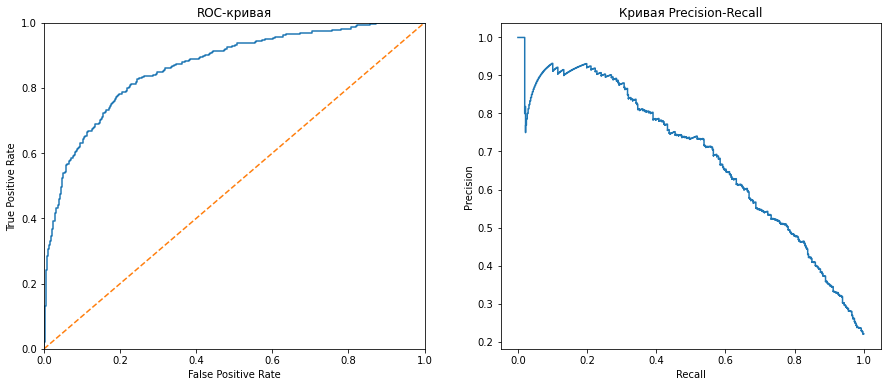

In [36]:
model = clf2.best_estimator_
model.fit(train_valid_features, train_valid_target)
test_probabilities_one = model.predict_proba(test_features)[:,1]

fpr, tpr, thresholds1 = roc_curve(test_target, test_probabilities_one)
precision, recall, thresholds2 = precision_recall_curve(test_target, test_probabilities_one)

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.subplot(122)
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Кривая Precision-Recall')
plt.show()

**Вывод:** при построении модели "Случайный лес" наилучшие значения метрик качества были получены при подборе гиперпараметров и при учёте взвешивания классов. На тестовой выборке получено значение F1-меры равное 0,63. Это значение превышает требуемое в проекте с запасом. Также получились высокие значения других рассмотренных метрик качества (0,84 для accuracy и более 0,86 для AUC-ROC). 

## Общий вывод

В проекте была выполнена базовая предобработка данных из источника. Также были подготовлены признаки для дальнейшего построения моделей. При подготовке признаков были применены техники прямого кодирования и масштабирования признаков. Далее было произведено разбиение исходных данных на обучающую и тестовую выборки с использованием стратификации по целевому признаку.

На первом этапе перед построением реальных моделей была исследована константная модель, предсказывающая единичные значения целевого признака. Полученные результаты совпали с ожидаемыми в теории значениями, а полученное значение F1-меры показало число, которое точно необходимо превысить в реальных моделях.

На втором этапе была построена модель логистической регрессии без учёта дисбаланса классов. В результате получилось неудовлетворительное значение F1-меры, практически равное аналогичному значению для константной модели.

На третьем этапе были рассмотрены три разные модели с попытками учёта дисбаланса классов:
- при построении модели логистической регрессии наилучшие значения метрик качества были получены при учёте взвешивания классов в гиперпараметре class_weight, а также при обучении модели на уменьшенной выборке. Результаты наилучшие для рассмотренной модели, но неудовлетворительные в рамках решения поставленной в проекте задачи;
- при построении модели "Дерево решений" наилучшие значения метрик качества были получены при подборе гиперпараметров, при учёте взвешивания классов, а также при увеличении порога классификации до 0,76. При увеличении порога достигается требуемое значение F1-меры.;
- при построении модели "Случайный лес" наилучшие значения метрик качества были получены при подборе гиперпараметров и при учёте взвешивания классов. На тестовой выборке получено значение F1-меры равное 0,63. Это значение превышает требуемое в проекте с запасом. Также получились высокие значения других рассмотренных метрик качества (0,84 для accuracy и более 0,86 для AUC-ROC). 

Для модели "Случайный лес", показавшей наилучшие результаты, были построены ROC- и PR-кривые, которые подтвердили высокое качество модели. 